# Clustering

## 1. Import Libraries and Settings

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from mpl_toolkits.mplot3d import Axes3D


warnings.filterwarnings('ignore')

# Settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Import Data Set

In [119]:
# Load the RFM data created in notebook 1
rfm = pd.read_csv("../data/OnlineRetail_RFM_Data.csv")
print(f"Dataset shape: {rfm.shape}")
rfm.head()

Dataset shape: (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## 3. Data Transformation for Clustering
### 3.1 Log Transformation

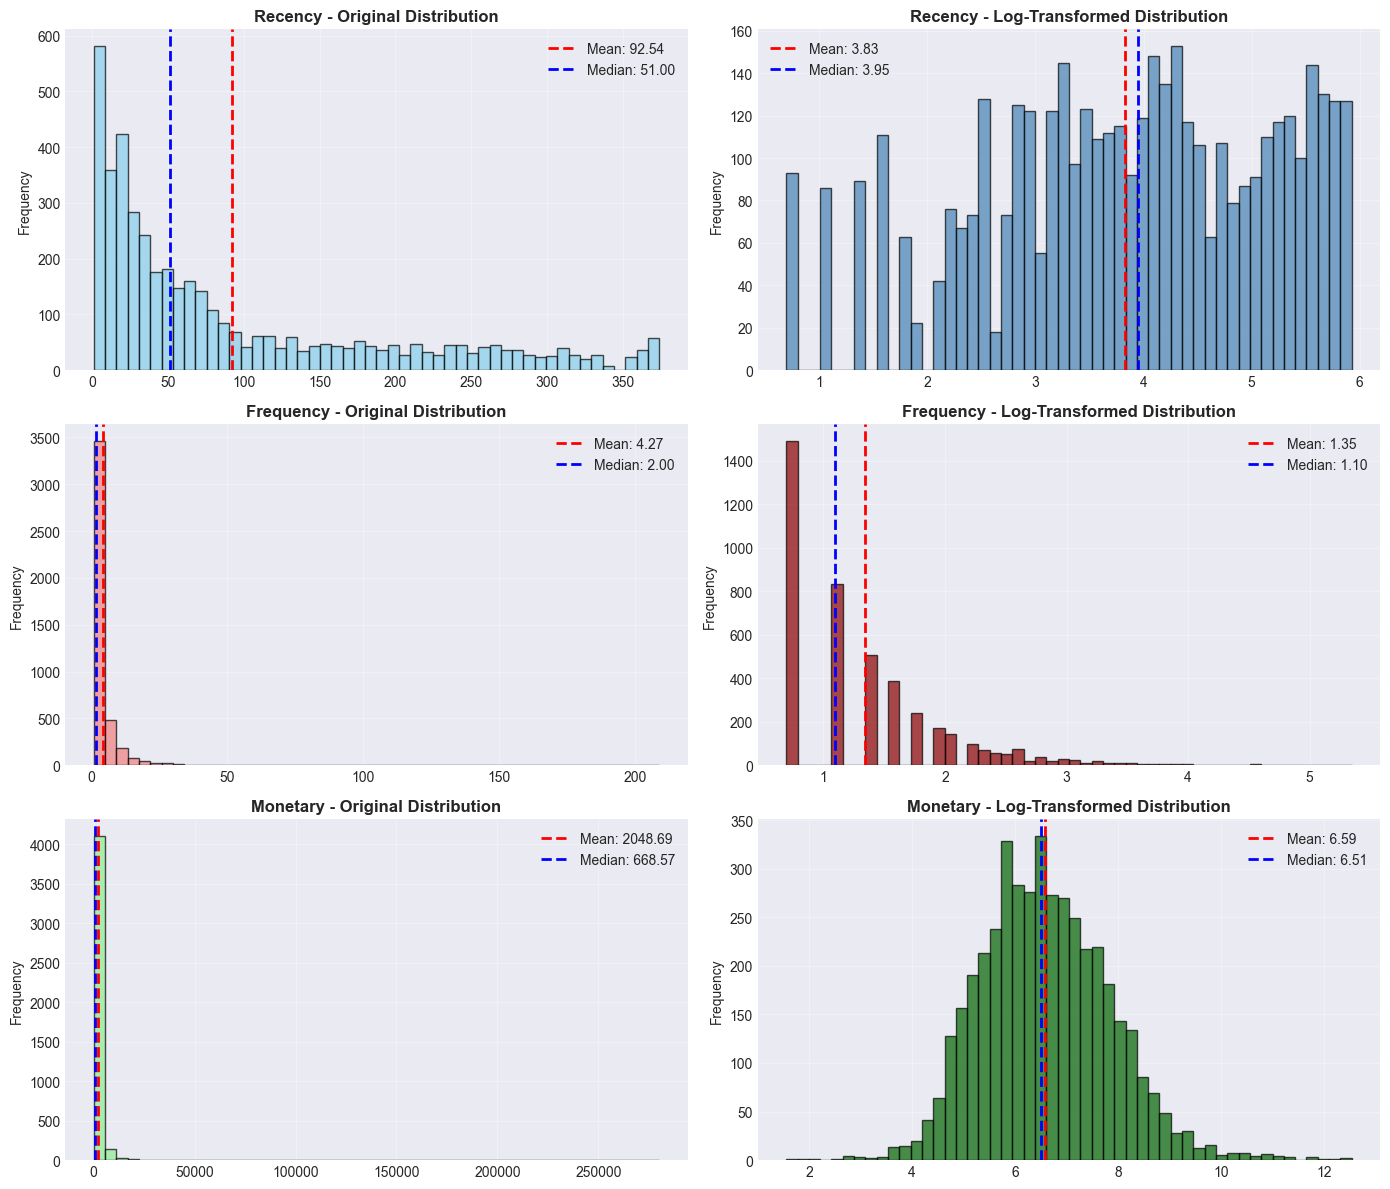


Skewness Analysis - Deciding Which Features to Transform:
Rule: Only apply log transformation if it significantly reduces skewness
      (Improvement > 1.0 is considered significant)

Recency:
  Original Skewness:    1.246
  Log-Transformed:     -0.379
  Improvement:          0.867
  Decision: ✗ SKIP log transformation (minimal improvement)

Frequency:
  Original Skewness:   12.067
  Log-Transformed:      1.209
  Improvement:         10.858
  Decision: ✓ APPLY log transformation (significant improvement)

Monetary:
  Original Skewness:   19.339
  Log-Transformed:      0.397
  Improvement:         18.943
  Decision: ✓ APPLY log transformation (significant improvement)



In [120]:
# First, let's evaluate log transformation for all features to see which ones benefit
rfm_log_test = rfm.copy()
rfm_log_test['Recency_log'] = np.log1p(rfm_log_test['Recency'])
rfm_log_test['Frequency_log'] = np.log1p(rfm_log_test['Frequency'])
rfm_log_test['Monetary_log'] = np.log1p(rfm_log_test['Monetary'])

# Compare distributions before and after transformation
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

features = ['Recency', 'Frequency', 'Monetary']
colors_original = ['skyblue', 'lightcoral', 'lightgreen']
colors_log = ['steelblue', 'darkred', 'darkgreen']

for idx, (feature, color_orig, color_log) in enumerate(zip(features, colors_original, colors_log)):
    # Original distribution
    axes[idx, 0].hist(rfm_log_test[feature], bins=50, edgecolor='black', alpha=0.7, color=color_orig)
    axes[idx, 0].set_title(f'{feature} - Original Distribution', fontweight='bold', fontsize=12)
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].axvline(rfm_log_test[feature].mean(), color='red', linestyle='--', 
                         label=f'Mean: {rfm_log_test[feature].mean():.2f}', linewidth=2)
    axes[idx, 0].axvline(rfm_log_test[feature].median(), color='blue', linestyle='--',
                         label=f'Median: {rfm_log_test[feature].median():.2f}', linewidth=2)
    axes[idx, 0].legend()
    axes[idx, 0].grid(alpha=0.3)
    
    # Log-transformed distribution
    axes[idx, 1].hist(rfm_log_test[f'{feature}_log'], bins=50, edgecolor='black', alpha=0.7, color=color_log)
    axes[idx, 1].set_title(f'{feature} - Log-Transformed Distribution', fontweight='bold', fontsize=12)
    axes[idx, 1].set_ylabel('Frequency')
    axes[idx, 1].axvline(rfm_log_test[f'{feature}_log'].mean(), color='red', linestyle='--',
                         label=f'Mean: {rfm_log_test[f"{feature}_log"].mean():.2f}', linewidth=2)
    axes[idx, 1].axvline(rfm_log_test[f'{feature}_log'].median(), color='blue', linestyle='--',
                         label=f'Median: {rfm_log_test[f"{feature}_log"].median():.2f}', linewidth=2)
    axes[idx, 1].legend()
    axes[idx, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print skewness comparison to decide which features to transform
print("\nSkewness Analysis - Deciding Which Features to Transform:")
print("="*70)
print("Rule: Only apply log transformation if it significantly reduces skewness")
print("      (Improvement > 1.0 is considered significant)\n")

for feature in features:
    original_skew = rfm_log_test[feature].skew()
    log_skew = rfm_log_test[f'{feature}_log'].skew()
    improvement = abs(original_skew) - abs(log_skew)
    
    print(f"{feature}:")
    print(f"  Original Skewness: {original_skew:>8.3f}")
    print(f"  Log-Transformed:   {log_skew:>8.3f}")
    print(f"  Improvement:       {improvement:>8.3f}")
    
    if improvement > 1.0:
        print(f"  Decision: ✓ APPLY log transformation (significant improvement)")
    else:
        print(f"  Decision: ✗ SKIP log transformation (minimal improvement)")
    print()

### 3.2 Scaling

In [121]:
# Based on the skewness analysis above, we apply log transformation selectively
# ONLY to features where it provides significant improvement

rfm_transformed = rfm.copy()

# Monetary
rfm_transformed['Monetary_log'] = np.log1p(rfm_transformed['Monetary'])

# Frequency
rfm_transformed['Frequency_log'] = np.log1p(rfm_transformed['Frequency'])

# Recency
rfm_transformed['Recency_original'] = rfm_transformed['Recency']

print("Transformation Decisions:")
print("="*70)
print("✓ Monetary   → Log-transformed (reduces extreme skewness)")
print("✓ Frequency  → Log-transformed (reduces skewness)")
print("✗ Recency    → Original values (log provides no benefit)")
print("="*70)

Transformation Decisions:
✓ Monetary   → Log-transformed (reduces extreme skewness)
✓ Frequency  → Log-transformed (reduces skewness)
✗ Recency    → Original values (log provides no benefit)



Scaled Data Statistics:
       Recency_scaled  Frequency_scaled  Monetary_scaled
count    4.338000e+03      4.338000e+03     4.338000e+03
mean     2.702618e-17     -8.189750e-18    -3.734526e-16
std      1.000115e+00      1.000115e+00     1.000115e+00
min     -9.153401e-01     -9.552143e-01    -3.997811e+00
25%     -7.453445e-01     -9.552143e-01    -6.835802e-01
50%     -4.153533e-01     -3.615828e-01    -6.510929e-02
75%      4.946227e-01      6.532370e-01     6.572178e-01
max      2.814561e+00      5.858535e+00     4.732381e+00


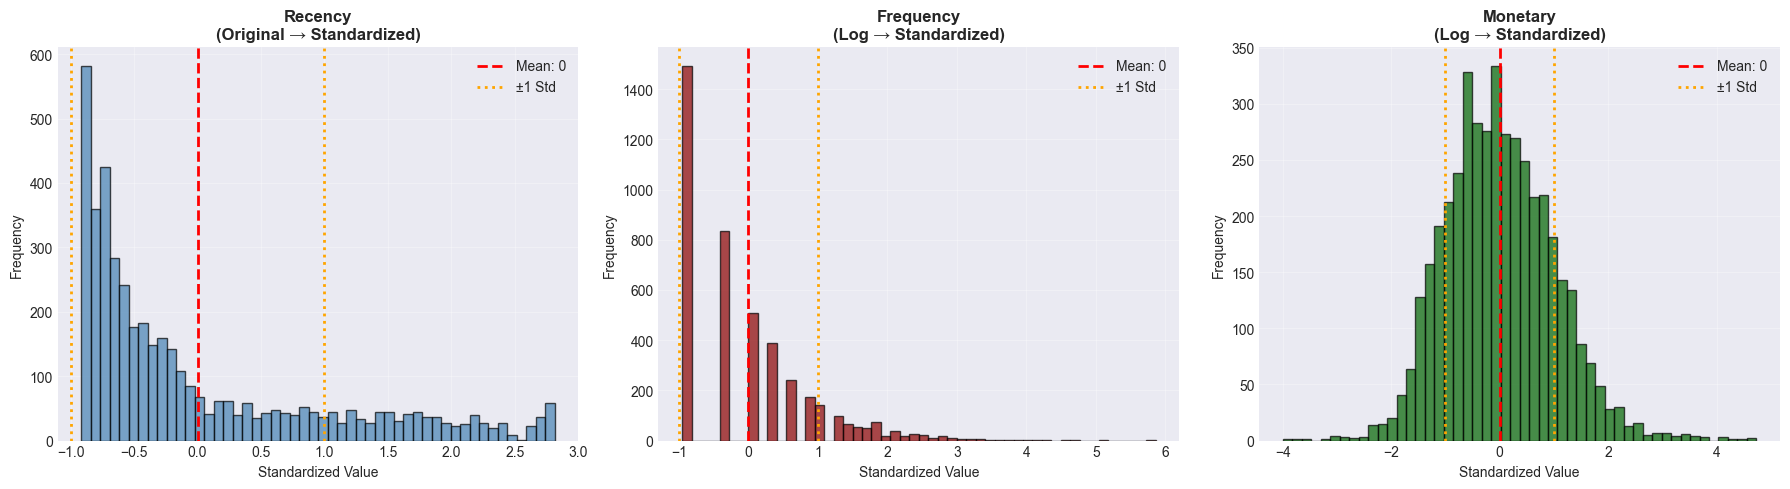

In [122]:
scaler = StandardScaler()

# Prepare the features for scaling
features_for_clustering = rfm_transformed[['Recency_original', 'Frequency_log', 'Monetary_log']].copy()
features_for_clustering.columns = ['Recency', 'Frequency', 'Monetary']

# Apply standardization
rfm_scaled_values = scaler.fit_transform(features_for_clustering)
rfm_scaled = pd.DataFrame(rfm_scaled_values, 
                          columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'],
                          index=rfm.index)

# Add CustomerID for reference
rfm_scaled['CustomerID'] = rfm['CustomerID'].values

print("\nScaled Data Statistics:")
print("="*70)
print(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']].describe())


# Visualize scaled distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

features_scaled = ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
titles = ['Recency\n(Original → Standardized)', 
          'Frequency\n(Log → Standardized)', 
          'Monetary\n(Log → Standardized)']
colors = ['steelblue', 'darkred', 'darkgreen']

for idx, (feature, title, color) in enumerate(zip(features_scaled, titles, colors)):
    axes[idx].hist(rfm_scaled[feature], bins=50, edgecolor='black', alpha=0.7, color=color)
    axes[idx].set_title(title, fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_xlabel('Standardized Value')
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean: 0')
    axes[idx].axvline(rfm_scaled[feature].std(), color='orange', linestyle=':', linewidth=2, label='±1 Std')
    axes[idx].axvline(-rfm_scaled[feature].std(), color='orange', linestyle=':', linewidth=2)
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Determining Optimal Number of Clusters

### 4.1 Elbow Method

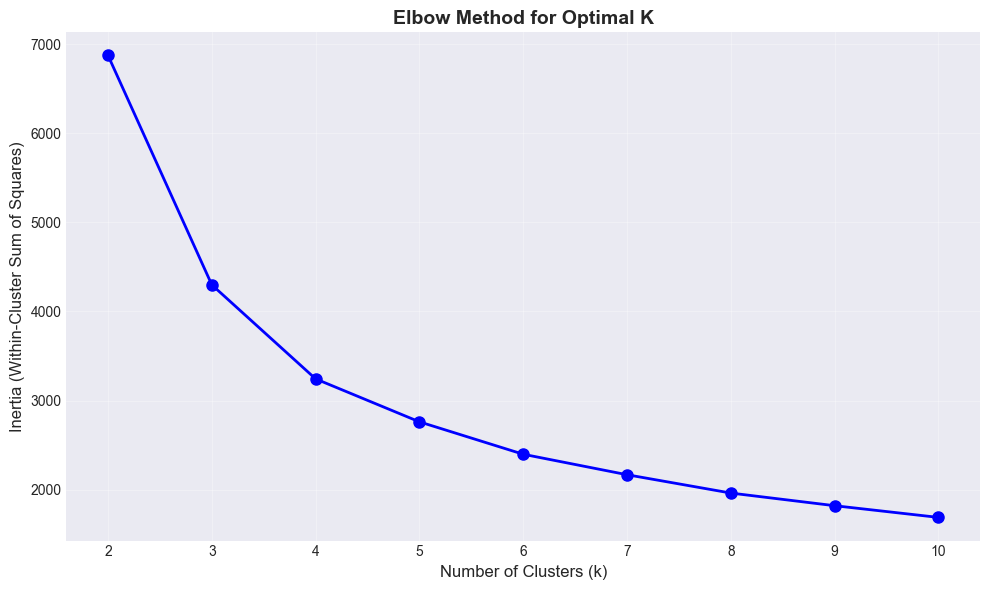

Inertia values:
k=2: 6874.93
k=3: 4299.07
k=4: 3243.03
k=5: 2760.79
k=6: 2396.85
k=7: 2166.96
k=8: 1961.09
k=9: 1819.16
k=10: 1687.78


In [123]:
# Test different numbers of clusters
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

print("Inertia values:")
for k, inertia in zip(k_range, inertias):
    print(f"k={k}: {inertia:.2f}")

### 4.2 Silhoutte Method

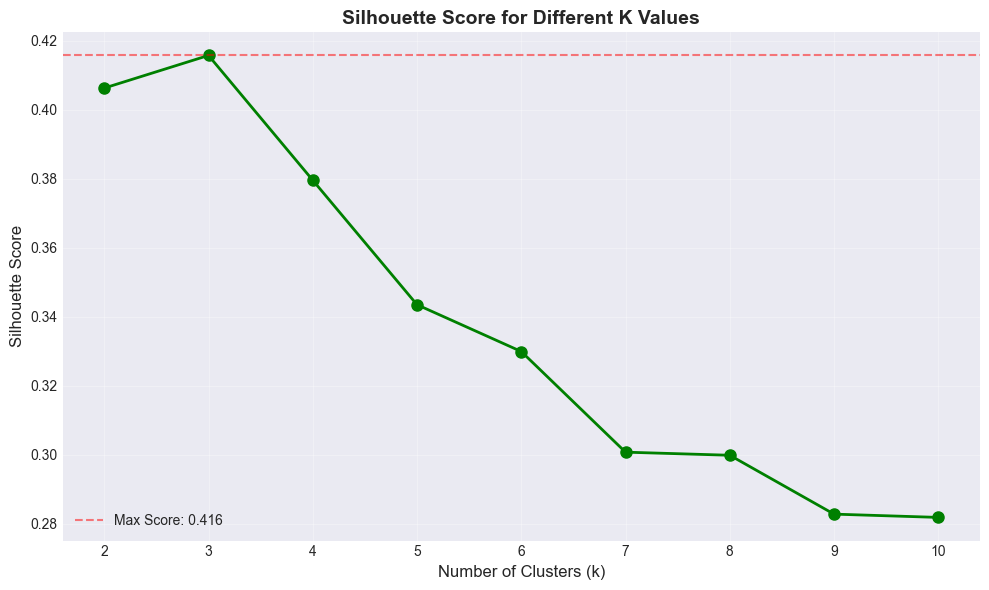


Silhouette Scores:
k=2: 0.4062
k=3: 0.4157
k=4: 0.3795
k=5: 0.3435
k=6: 0.3299
k=7: 0.3008
k=8: 0.2999
k=9: 0.2828
k=10: 0.2819

✓ Optimal k based on Silhouette Score: 3


In [124]:
# Calculate silhouette scores
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])
    silhouette_avg = silhouette_score(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score for Different K Values', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(k_range)
plt.axhline(y=max(silhouette_scores), color='r', linestyle='--', alpha=0.5, label=f'Max Score: {max(silhouette_scores):.3f}')
plt.legend()
plt.tight_layout()
plt.show()

print("\nSilhouette Scores:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")
    
# Find optimal k based on silhouette score
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✓ Optimal k based on Silhouette Score: {optimal_k}")

### 4.3 Davies-Boudin Index

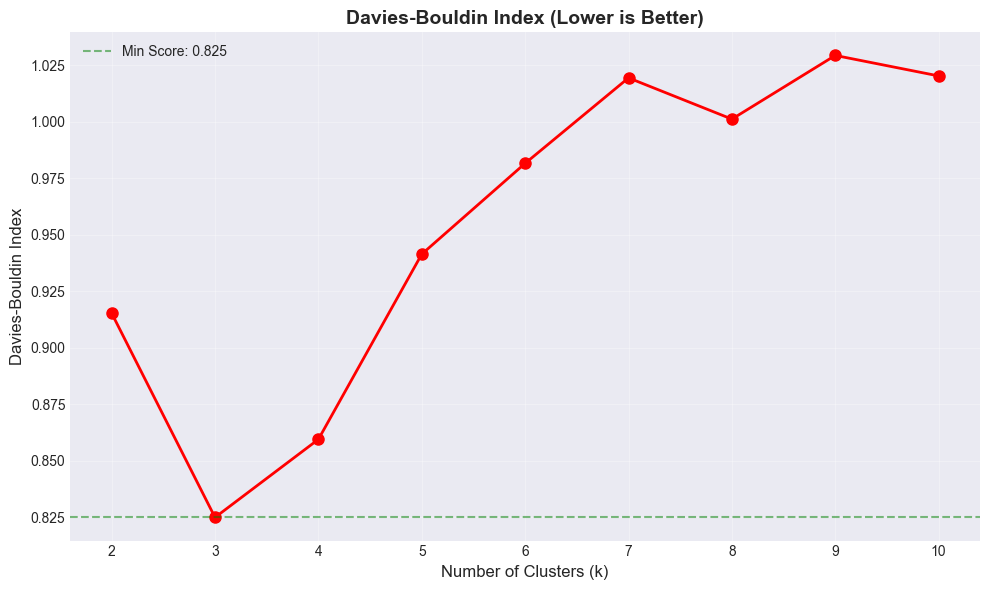


Davies-Bouldin Scores:
k=2: 0.9154
k=3: 0.8250
k=4: 0.8595
k=5: 0.9415
k=6: 0.9816
k=7: 1.0195
k=8: 1.0012
k=9: 1.0294
k=10: 1.0203

✓ Optimal k based on Davies-Bouldin Index: 3


In [125]:
# Calculate Davies-Bouldin scores (lower is better)
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])
    db_score = davies_bouldin_score(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], cluster_labels)
    db_scores.append(db_score)

# Plot Davies-Bouldin Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, db_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Davies-Bouldin Index', fontsize=12)
plt.title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(k_range)
plt.axhline(y=min(db_scores), color='g', linestyle='--', alpha=0.5, label=f'Min Score: {min(db_scores):.3f}')
plt.legend()
plt.tight_layout()
plt.show()

print("\nDavies-Bouldin Scores:")
for k, score in zip(k_range, db_scores):
    print(f"k={k}: {score:.4f}")

# Find optimal k based on DB score
optimal_k_db = k_range[db_scores.index(min(db_scores))]
print(f"\n✓ Optimal k based on Davies-Bouldin Index: {optimal_k_db}")

### 4.4 Calinski-Harabasz Index

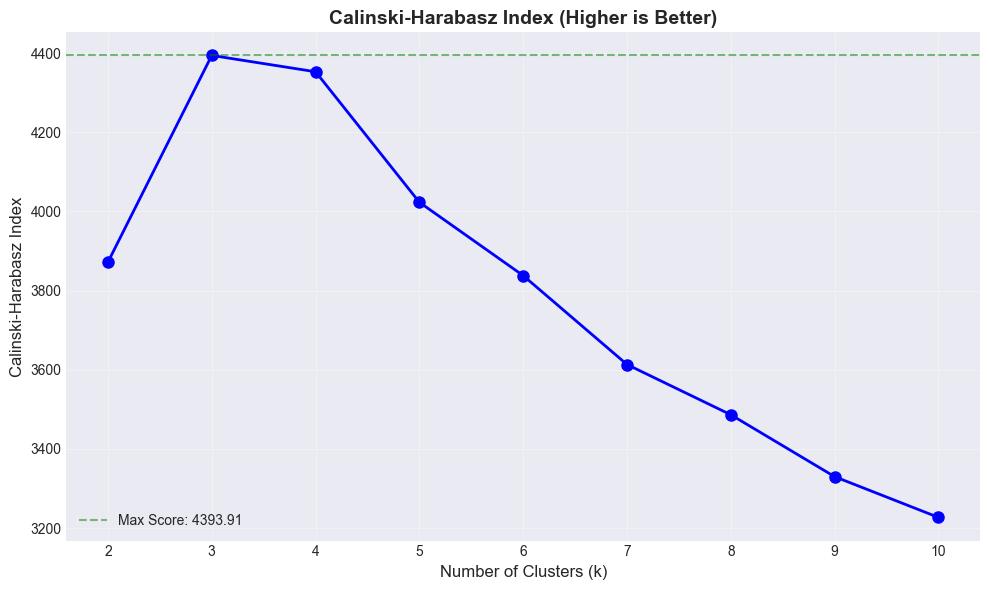


Calinski-Harabasz Scores:
k=2: 3871.91
k=3: 4393.91
k=4: 4352.69
k=5: 4023.05
k=6: 3837.86
k=7: 3613.30
k=8: 3486.41
k=9: 3330.09
k=10: 3227.19

✓ Optimal k based on Calinski-Harabasz Index: 3


In [126]:
# Calculate Calinski-Harabasz Index (higher is better)
chi_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])
    chi_score = calinski_harabasz_score(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']], cluster_labels)
    chi_scores.append(chi_score)

# Plot CHI Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, chi_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Calinski-Harabasz Index', fontsize=12)
plt.title('Calinski-Harabasz Index (Higher is Better)', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(k_range)
plt.axhline(y=max(chi_scores), color='g', linestyle='--', alpha=0.5, label=f'Max Score: {max(chi_scores):.2f}')
plt.legend()
plt.tight_layout()
plt.show()

print("\nCalinski-Harabasz Scores:")
for k, score in zip(k_range, chi_scores):
    print(f"k={k}: {score:.2f}")

# Find optimal k based on CHI
optimal_k_chi = k_range[chi_scores.index(max(chi_scores))]
print(f"\n✓ Optimal k based on Calinski-Harabasz Index: {optimal_k_chi}")


### 4.5 Combined Visualization

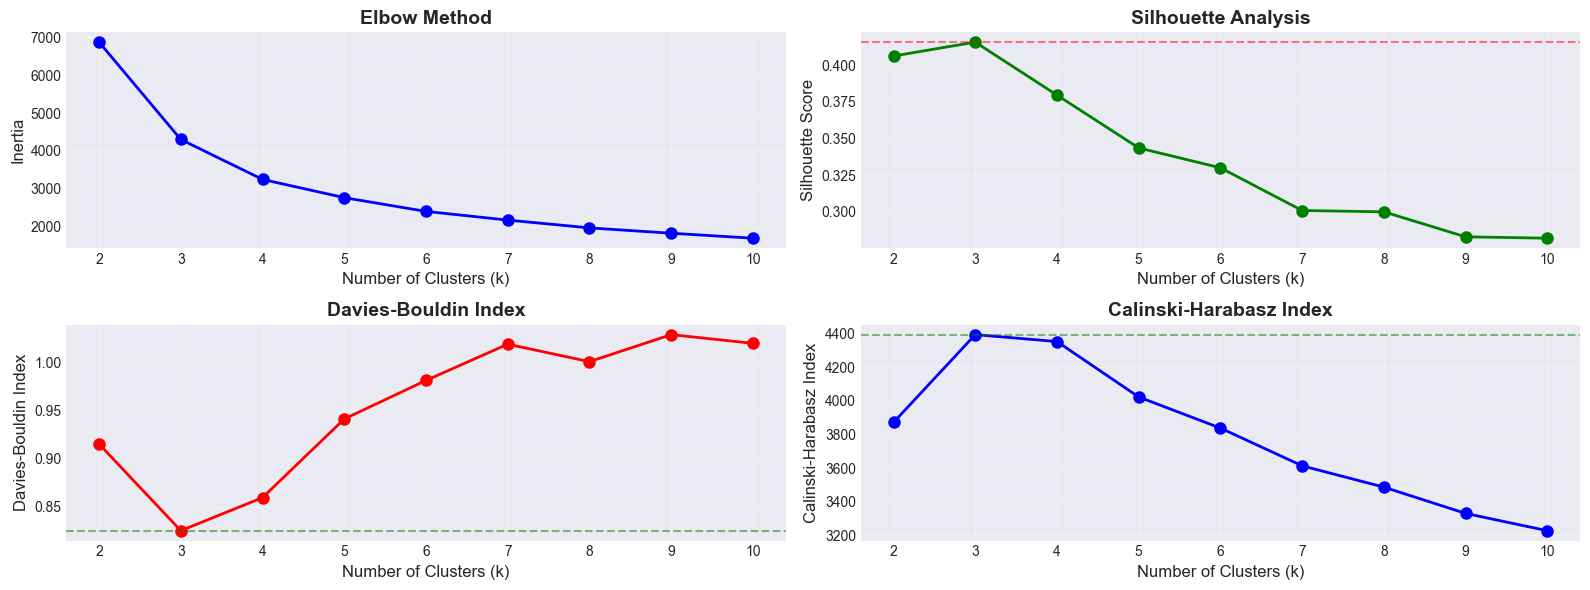

In [127]:
fig, axes = plt.subplots(2, 2, figsize=(16, 6))

# Elbow plot
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(k_range)

# Silhouette plot
axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(k_range)
axes[0, 1].axhline(y=max(silhouette_scores), color='r', linestyle='--', alpha=0.5)

# Davies-Bouldin plot
axes[1, 0].plot(k_range, db_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Index', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_xticks(k_range)
axes[1, 0].axhline(y=min(db_scores), color='g', linestyle='--', alpha=0.5)

# Calinski-Harabasz plot
axes[1, 1].plot(k_range, chi_scores, 'bo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Index', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Index', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].set_xticks(k_range)
axes[1, 1].axhline(y=max(chi_scores), color='g', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

From all 4 test, we find that three clusters is the optimal number.

## 5. K-means Clustering

### 5.1 Apply K-Means with Optimal K

In [128]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_scaled['Cluster'] = kmeans_final.fit_predict(rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']])

rfm['Cluster'] = rfm_scaled['Cluster']

print(f"K-Means clustering completed with k={optimal_k}")
print(f"\nCluster Distribution:")
print(rfm['Cluster'].value_counts().sort_index())

K-Means clustering completed with k=3

Cluster Distribution:
Cluster
0    1320
1     981
2    2037
Name: count, dtype: int64


### 5.2 Visualize Clusters in 3D

In [129]:
cluster_centers_scaled = kmeans_final.cluster_centers_

centers_df = pd.DataFrame(
    cluster_centers_scaled,
    columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
)
centers_df.index.name = 'Cluster'

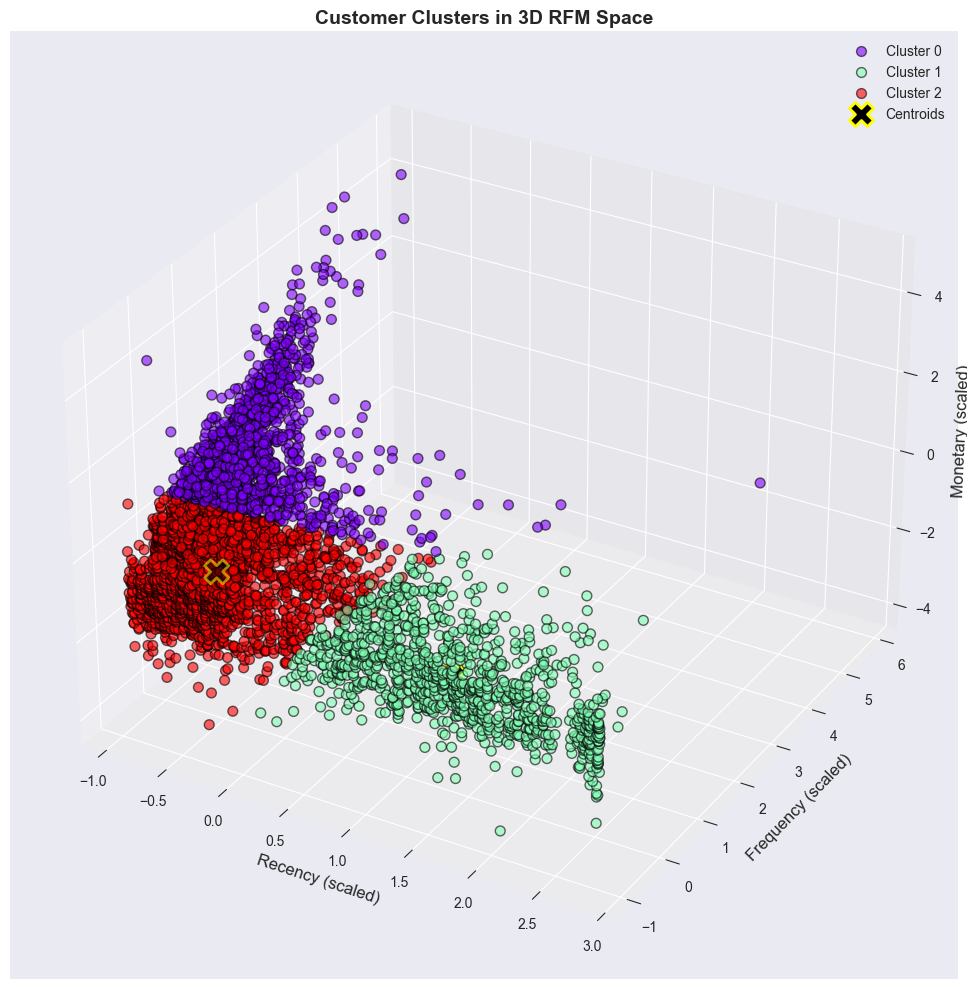

In [130]:
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.rainbow(np.linspace(0, 1, optimal_k))

for cluster in range(optimal_k):
    cluster_data = rfm_scaled[rfm_scaled['Cluster'] == cluster]
    ax.scatter(cluster_data['Recency_scaled'], 
               cluster_data['Frequency_scaled'], 
               cluster_data['Monetary_scaled'],
               c=[colors[cluster]], 
               label=f'Cluster {cluster}',
               s=50,
               alpha=0.6,
               edgecolors='k')

ax.scatter(cluster_centers_scaled[:, 0], 
           cluster_centers_scaled[:, 1], 
           cluster_centers_scaled[:, 2],
           c='black', 
           marker='X', 
           s=300, 
           label='Centroids',
           edgecolors='yellow',
           linewidths=2)

ax.set_xlabel('Recency (scaled)', fontsize=12)
ax.set_ylabel('Frequency (scaled)', fontsize=12)
ax.set_zlabel('Monetary (scaled)', fontsize=12)
ax.set_title('Customer Clusters in 3D RFM Space', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

### 5.3 Visualize Clusters in 2D

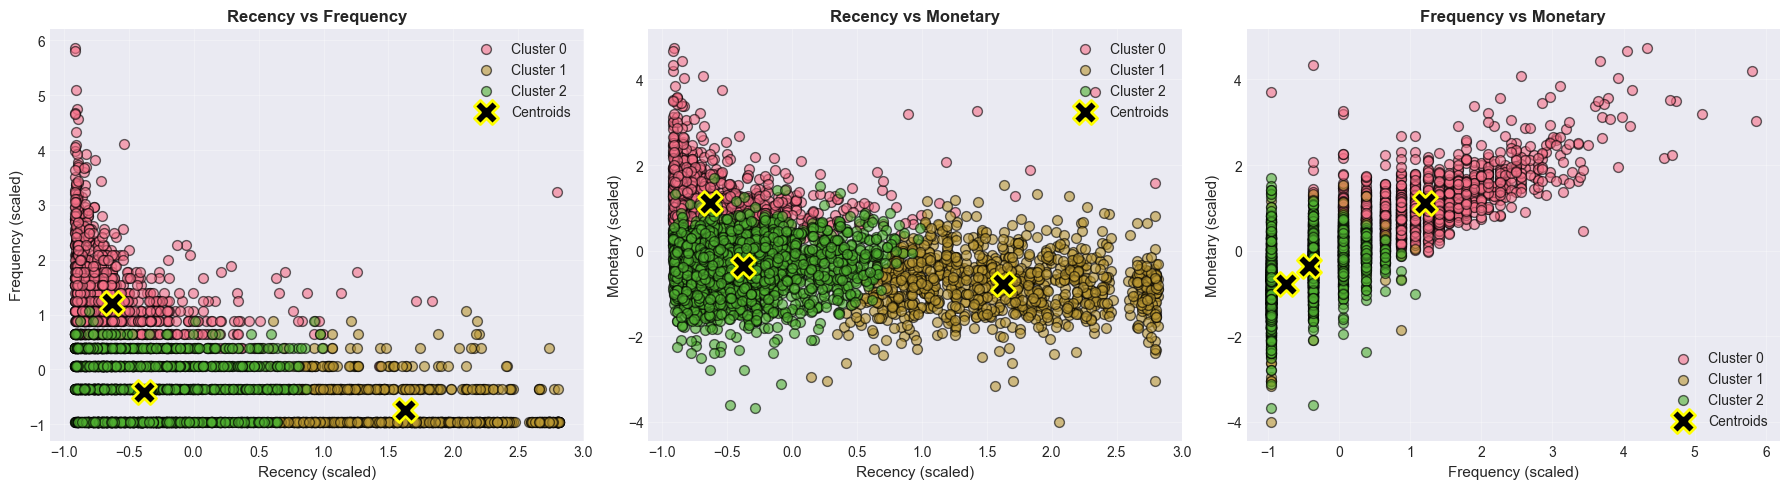

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency vs Frequency
for cluster in range(optimal_k):
    cluster_data = rfm_scaled[rfm_scaled['Cluster'] == cluster]
    axes[0].scatter(cluster_data['Recency_scaled'], 
                    cluster_data['Frequency_scaled'],
                    label=f'Cluster {cluster}',
                    s=50,
                    alpha=0.6,
                    edgecolors='k')
axes[0].scatter(cluster_centers_scaled[:, 0], cluster_centers_scaled[:, 1],
                c='black', marker='X', s=300, edgecolors='yellow', linewidths=2, label='Centroids')
axes[0].set_xlabel('Recency (scaled)', fontsize=11)
axes[0].set_ylabel('Frequency (scaled)', fontsize=11)
axes[0].set_title('Recency vs Frequency', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Recency vs Monetary
for cluster in range(optimal_k):
    cluster_data = rfm_scaled[rfm_scaled['Cluster'] == cluster]
    axes[1].scatter(cluster_data['Recency_scaled'], 
                    cluster_data['Monetary_scaled'],
                    label=f'Cluster {cluster}',
                    s=50,
                    alpha=0.6,
                    edgecolors='k')
axes[1].scatter(cluster_centers_scaled[:, 0], cluster_centers_scaled[:, 2],
                c='black', marker='X', s=300, edgecolors='yellow', linewidths=2, label='Centroids')
axes[1].set_xlabel('Recency (scaled)', fontsize=11)
axes[1].set_ylabel('Monetary (scaled)', fontsize=11)
axes[1].set_title('Recency vs Monetary', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Frequency vs Monetary
for cluster in range(optimal_k):
    cluster_data = rfm_scaled[rfm_scaled['Cluster'] == cluster]
    axes[2].scatter(cluster_data['Frequency_scaled'], 
                    cluster_data['Monetary_scaled'],
                    label=f'Cluster {cluster}',
                    s=50,
                    alpha=0.6,
                    edgecolors='k')
axes[2].scatter(cluster_centers_scaled[:, 1], cluster_centers_scaled[:, 2],
                c='black', marker='X', s=300, edgecolors='yellow', linewidths=2, label='Centroids')
axes[2].set_xlabel('Frequency (scaled)', fontsize=11)
axes[2].set_ylabel('Monetary (scaled)', fontsize=11)
axes[2].set_title('Frequency vs Monetary', fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Cluster Profiling

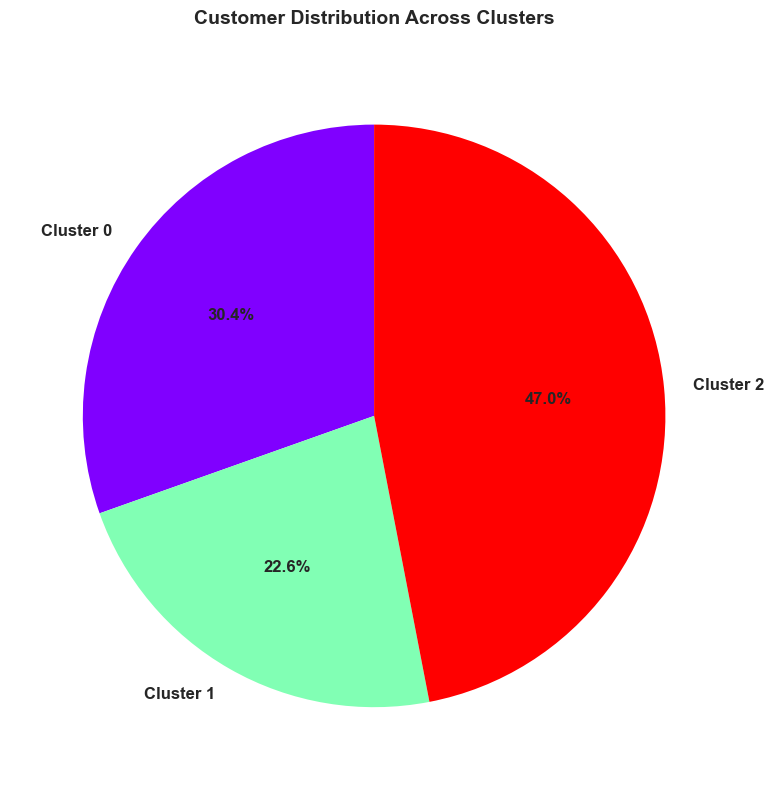


Cluster Sizes:
Cluster 0: 1320 customers (30.4%)
Cluster 1: 981 customers (22.6%)
Cluster 2: 2037 customers (47.0%)


In [132]:
# Pie chart of cluster distribution
plt.figure(figsize=(10, 8))
cluster_sizes = rfm['Cluster'].value_counts().sort_index()
colors_pie = plt.cm.rainbow(np.linspace(0, 1, optimal_k))

plt.pie(cluster_sizes, labels=[f'Cluster {i}' for i in cluster_sizes.index], 
        autopct='%1.1f%%', startangle=90, colors=colors_pie,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Customer Distribution Across Clusters', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCluster Sizes:")
for cluster, size in cluster_sizes.items():
    percentage = (size / len(rfm)) * 100
    print(f"Cluster {cluster}: {size} customers ({percentage:.1f}%)")

In [133]:
# Calculate mean RFM values for each cluster (in original scale, not scaled)
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'Monetary': ['mean', 'median', 'min', 'max'],
    'CustomerID': 'count'
}).round(2)

cluster_profile.columns = ['_'.join(col).strip() for col in cluster_profile.columns.values]
cluster_profile = cluster_profile.rename(columns={'CustomerID_count': 'Customer_Count'})

print("\nCluster Profile (Original Scale):")
print("="*100)
print(cluster_profile)


Cluster Profile (Original Scale):
         Recency_mean  Recency_median  Recency_min  Recency_max  Frequency_mean  Frequency_median  Frequency_min  Frequency_max  \
Cluster                                                                                                                           
0               30.10            17.0            1          372            9.84               7.0              1            209   
1              255.11           253.0          107          374            1.39               1.0              1              7   
2               54.70            45.0            1          191            2.05               2.0              1              7   

         Monetary_mean  Monetary_median  Monetary_min  Monetary_max  Customer_Count  
Cluster                                                                              
0              5492.04          2570.50        621.68     280206.02            1320  
1               397.17           290.51          3.

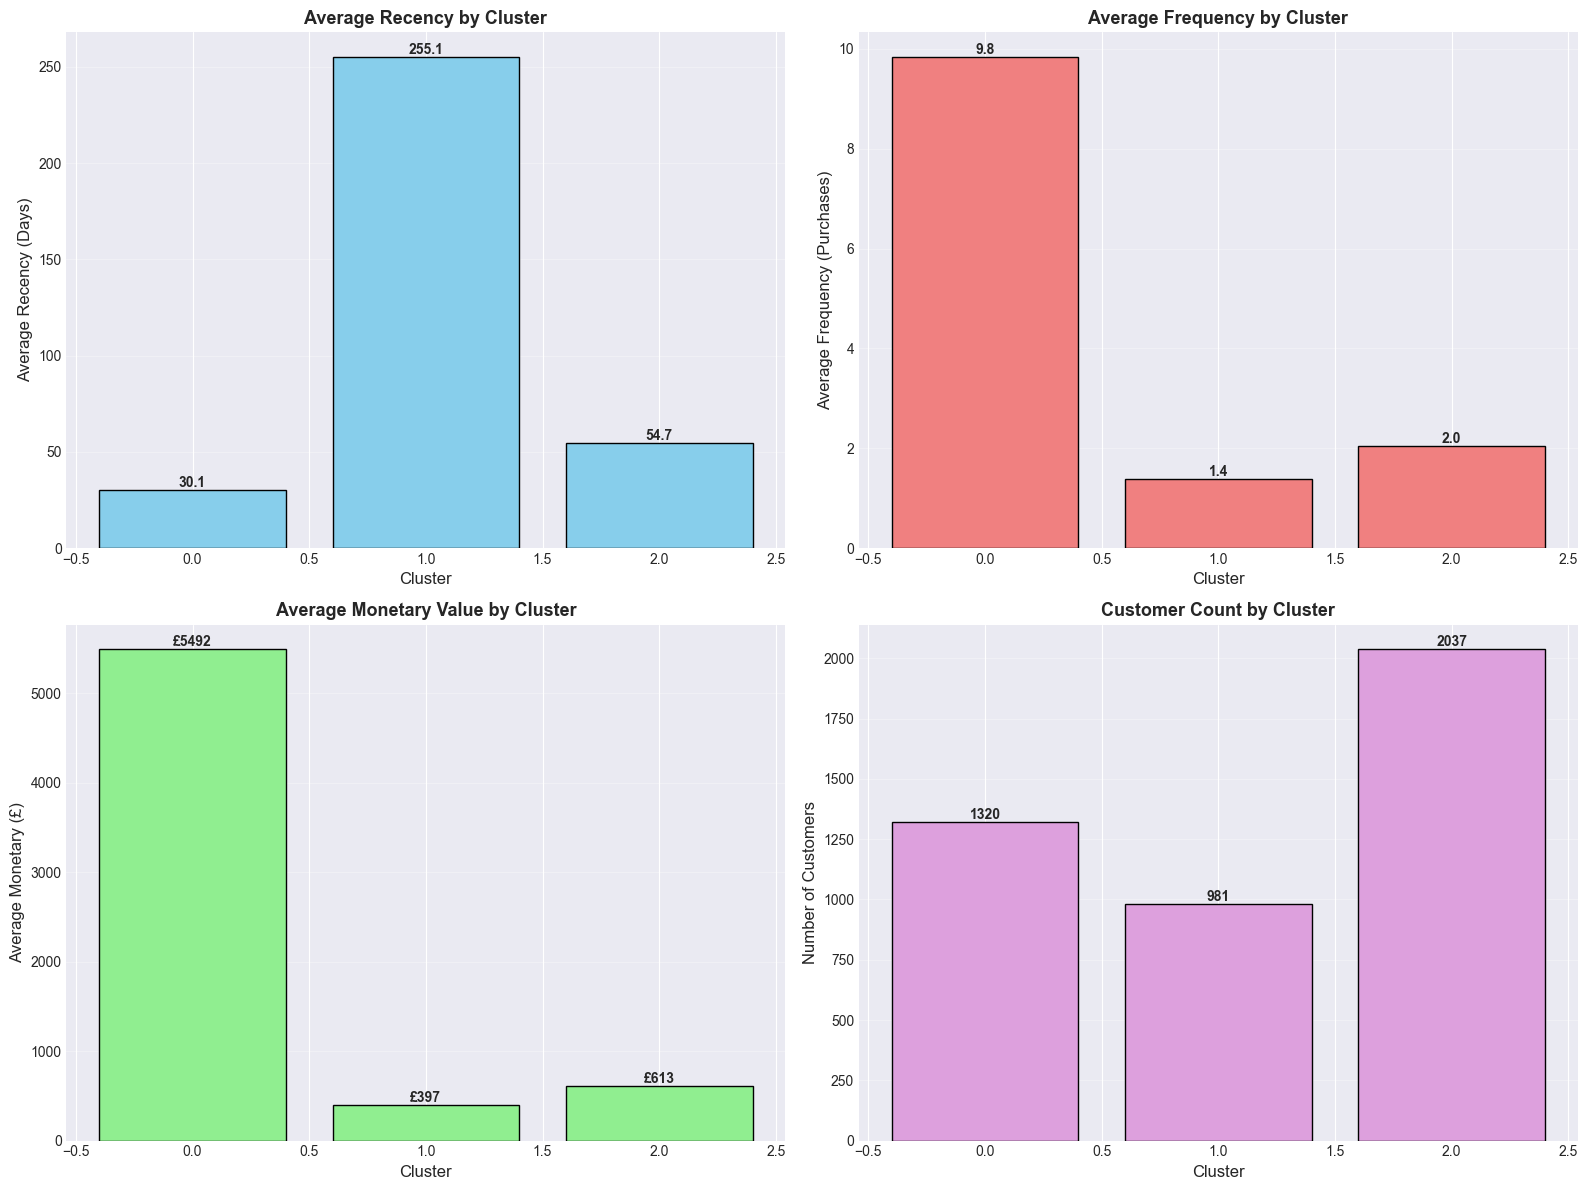

In [134]:
# Calculate mean values for visualization
cluster_means = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

cluster_means.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Recency by Cluster
axes[0, 0].bar(cluster_means.index, cluster_means['Avg_Recency'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Cluster', fontsize=12)
axes[0, 0].set_ylabel('Average Recency (Days)', fontsize=12)
axes[0, 0].set_title('Average Recency by Cluster', fontweight='bold', fontsize=13)
axes[0, 0].grid(alpha=0.3, axis='y')
for i, v in enumerate(cluster_means['Avg_Recency']):
    axes[0, 0].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Frequency by Cluster
axes[0, 1].bar(cluster_means.index, cluster_means['Avg_Frequency'], color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Cluster', fontsize=12)
axes[0, 1].set_ylabel('Average Frequency (Purchases)', fontsize=12)
axes[0, 1].set_title('Average Frequency by Cluster', fontweight='bold', fontsize=13)
axes[0, 1].grid(alpha=0.3, axis='y')
for i, v in enumerate(cluster_means['Avg_Frequency']):
    axes[0, 1].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Monetary by Cluster
axes[1, 0].bar(cluster_means.index, cluster_means['Avg_Monetary'], color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('Cluster', fontsize=12)
axes[1, 0].set_ylabel('Average Monetary (£)', fontsize=12)
axes[1, 0].set_title('Average Monetary Value by Cluster', fontweight='bold', fontsize=13)
axes[1, 0].grid(alpha=0.3, axis='y')
for i, v in enumerate(cluster_means['Avg_Monetary']):
    axes[1, 0].text(i, v, f'£{v:.0f}', ha='center', va='bottom', fontweight='bold')

# Customer Count by Cluster
axes[1, 1].bar(cluster_means.index, cluster_means['Customer_Count'], color='plum', edgecolor='black')
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_ylabel('Number of Customers', fontsize=12)
axes[1, 1].set_title('Customer Count by Cluster', fontweight='bold', fontsize=13)
axes[1, 1].grid(alpha=0.3, axis='y')
for i, v in enumerate(cluster_means['Customer_Count']):
    axes[1, 1].text(i, v, f'{int(v)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 6.1 Assign Names to Clusters

In [135]:
cluster_names_map = {
    0: 'Frequent_High-Value_Customers',
    1: 'At-Risk_Customers',  
    2: 'Low_Value_Customers'
}

rfm['Segment_Name'] = rfm['Cluster'].map(cluster_names_map)

segment_mapping = rfm.groupby('Cluster')['Segment_Name'].first()
for cluster, name in segment_mapping.items():
    count = len(rfm[rfm['Cluster'] == cluster])
    print(f"Cluster {cluster} → {name} ({count} customers)")


Cluster 0 → Frequent_High-Value_Customers (1320 customers)
Cluster 1 → At-Risk_Customers (981 customers)
Cluster 2 → Low_Value_Customers (2037 customers)


### 6.2 Final Summary

In [136]:
segment_summary = rfm.groupby('Segment_Name').agg({
    'Recency': ['mean'],
    'Frequency': ['mean'],
    'Monetary': ['mean', 'sum'],
    'CustomerID': 'count'
}).round(2)

segment_summary.columns = ['_'.join(col).strip() for col in segment_summary.columns.values]
segment_summary = segment_summary.rename(columns={'CustomerID_count': 'Customer_Count'})

segment_summary['Pct_Customers'] = (segment_summary['Customer_Count'] / len(rfm) * 100).round(1)
segment_summary['Pct_Revenue'] = (segment_summary['Monetary_sum'] / rfm['Monetary'].sum() * 100).round(1)

segment_summary = segment_summary.sort_values('Monetary_mean', ascending=False)

print("\nDetailed Segment Analysis:")
print(segment_summary)


Detailed Segment Analysis:
                               Recency_mean  Frequency_mean  Monetary_mean  Monetary_sum  Customer_Count  Pct_Customers  Pct_Revenue
Segment_Name                                                                                                                        
Frequent_High-Value_Customers         30.10            9.84        5492.04    7249492.37            1320           30.4         81.6
Low_Value_Customers                   54.70            2.05         612.71    1248089.72            2037           47.0         14.0
At-Risk_Customers                    255.11            1.39         397.17     389626.80             981           22.6          4.4


## 7. Model Evaluation

### 7.1 Silhouette Analysis

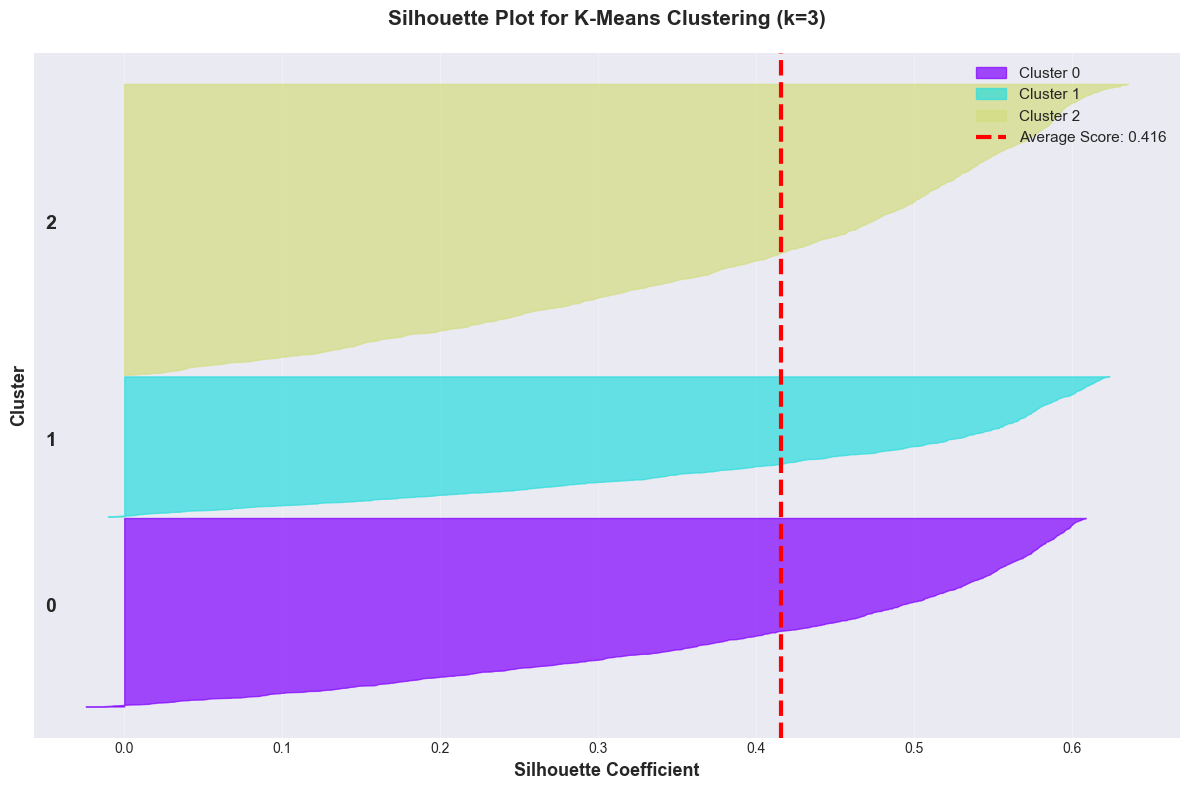


SILHOUETTE ANALYSIS RESULTS

Overall Silhouette Score: 0.4157

Interpretation:
  • Score close to +1: Sample is far from neighboring clusters (good)
  • Score close to 0: Sample is on or very close to decision boundary
  • Score close to -1: Sample might have been assigned to wrong cluster (bad)

Silhouette Score by Cluster:
  Cluster 0: 0.4156 (1320 customers)
  Cluster 1: 0.4277 (981 customers)
  Cluster 2: 0.4100 (2037 customers)



In [137]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Calculate silhouette scores for each sample
X_clustering = rfm_scaled[['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']]
silhouette_vals = silhouette_samples(X_clustering, rfm['Cluster'])

# Determine optimal_k (should be 3 based on your analysis)
optimal_k = rfm['Cluster'].nunique()

# Create silhouette plot
fig, ax = plt.subplots(figsize=(12, 8))

y_lower = 10
for i in range(optimal_k):
    # Get silhouette scores for cluster i
    cluster_silhouette_vals = silhouette_vals[rfm['Cluster'] == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.rainbow(float(i) / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7,
                     label=f'Cluster {i}')
    
    # Label the silhouette plots with their cluster numbers
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'{i}', fontsize=14, fontweight='bold')
    
    y_lower = y_upper + 10

# Add average silhouette score line
silhouette_avg = silhouette_score(X_clustering, rfm['Cluster'])
ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=3,
           label=f'Average Score: {silhouette_avg:.3f}')

ax.set_xlabel("Silhouette Coefficient", fontsize=13, fontweight='bold')
ax.set_ylabel("Cluster", fontsize=13, fontweight='bold')
ax.set_title(f"Silhouette Plot for K-Means Clustering (k={optimal_k})", 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.set_yticks([])
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("SILHOUETTE ANALYSIS RESULTS")
print(f"{'='*70}")
print(f"\nOverall Silhouette Score: {silhouette_avg:.4f}")
print("\nInterpretation:")
print("  • Score close to +1: Sample is far from neighboring clusters (good)")
print("  • Score close to 0: Sample is on or very close to decision boundary")
print("  • Score close to -1: Sample might have been assigned to wrong cluster (bad)")

# Calculate per-cluster silhouette scores
print("\nSilhouette Score by Cluster:")
for i in range(optimal_k):
    cluster_sil_score = silhouette_vals[rfm['Cluster'] == i].mean()
    cluster_size = (rfm['Cluster'] == i).sum()
    print(f"  Cluster {i}: {cluster_sil_score:.4f} ({cluster_size} customers)")

print(f"\n{'='*70}")

### 7.2 Comprehensive Evaluation Metrics

In [138]:
# Calculate all evaluation metrics
print("\n" + "="*80)
print("CLUSTERING QUALITY METRICS - COMPREHENSIVE EVALUATION")
print("="*80)

# 1. Silhouette Score (already calculated above)
sil_score = silhouette_score(X_clustering, rfm['Cluster'])
print(f"\n1. Silhouette Score: {sil_score:.4f}")
print("   Range: [-1, 1], Higher is better")
if sil_score > 0.7:
    print("   ✓ Interpretation: EXCELLENT - Strong clustering structure")
    sil_quality = "EXCELLENT"
elif sil_score > 0.5:
    print("   ✓ Interpretation: GOOD - Well-defined clusters")
    sil_quality = "GOOD"
elif sil_score > 0.3:
    print("   ⚠ Interpretation: ACCEPTABLE - Moderate cluster structure")
    sil_quality = "ACCEPTABLE"
else:
    print("   ✗ Interpretation: POOR - Weak clustering, clusters may overlap")
    sil_quality = "POOR"

# 2. Davies-Bouldin Index
db_score = davies_bouldin_score(X_clustering, rfm['Cluster'])
print(f"\n2. Davies-Bouldin Index: {db_score:.4f}")
print("   Range: [0, ∞], Lower is better")
if db_score < 0.8:
    print("   ✓ Interpretation: EXCELLENT - Clusters are well-separated")
    db_quality = "EXCELLENT"
elif db_score < 1.0:
    print("   ✓ Interpretation: GOOD - Acceptable cluster separation")
    db_quality = "GOOD"
elif db_score < 1.5:
    print("   ⚠ Interpretation: ACCEPTABLE - Some cluster overlap")
    db_quality = "ACCEPTABLE"
else:
    print("   ✗ Interpretation: POOR - Significant cluster overlap")
    db_quality = "POOR"

# 3. Calinski-Harabasz Score
ch_score = calinski_harabasz_score(X_clustering, rfm['Cluster'])
print(f"\n3. Calinski-Harabasz Score: {ch_score:.2f}")
print("   Range: [0, ∞], Higher is better")
if ch_score > 500:
    print("   ✓ Interpretation: EXCELLENT - Dense, well-separated clusters")
    ch_quality = "EXCELLENT"
elif ch_score > 100:
    print("   ✓ Interpretation: GOOD - Clusters are well-defined")
    ch_quality = "GOOD"
elif ch_score > 50:
    print("   ⚠ Interpretation: ACCEPTABLE - Moderate cluster quality")
    ch_quality = "ACCEPTABLE"
else:
    print("   ✗ Interpretation: POOR - Weak cluster definition")
    ch_quality = "POOR"

# 4. Inertia (from the K-means model)
# We need to get the inertia from the fitted model
# Assuming you have kmeans_final from Section 5
try:
    inertia = kmeans_final.inertia_
    print(f"\n4. Inertia (Within-Cluster Sum of Squares): {inertia:.2f}")
    print("   Sum of squared distances of samples to their closest centroid")
    print("   Lower is better, but must be contextualized with elbow method")
except:
    print("\n4. Inertia: Not available (kmeans_final not found)")


CLUSTERING QUALITY METRICS - COMPREHENSIVE EVALUATION

1. Silhouette Score: 0.4157
   Range: [-1, 1], Higher is better
   ⚠ Interpretation: ACCEPTABLE - Moderate cluster structure

2. Davies-Bouldin Index: 0.8250
   Range: [0, ∞], Lower is better
   ✓ Interpretation: GOOD - Acceptable cluster separation

3. Calinski-Harabasz Score: 4393.91
   Range: [0, ∞], Higher is better
   ✓ Interpretation: EXCELLENT - Dense, well-separated clusters

4. Inertia (Within-Cluster Sum of Squares): 4299.07
   Sum of squared distances of samples to their closest centroid
   Lower is better, but must be contextualized with elbow method


### 7.3 Final Evaluation Visualization

In [139]:
print("\n" + "="*80)
print("FINAL CLUSTERING EVALUATION SUMMARY")
print("="*80)

print(f"\nModel: K-Means Clustering with k={optimal_k}")
print(f"\nDataset: {len(rfm):,} customers")

print("\nSegments Identified:")
for segment_name in rfm['Segment_Name'].unique():
    count = (rfm['Segment_Name'] == segment_name).sum()
    pct = count / len(rfm) * 100
    print(f"  • {segment_name}: {count:,} customers ({pct:.1f}%)")

print("\n" + "-"*80)
print("QUALITY METRICS:")
print("-"*80)
print(f"  Silhouette Score:         {sil_score:.4f}  [{sil_quality}]")
print(f"  Davies-Bouldin Index:     {db_score:.4f}  [{db_quality}]")
print(f"  Calinski-Harabasz Score:  {ch_score:.2f}  [{ch_quality}]")
print(f"\n  Overall Quality:  {emoji} {overall}")

print("\n" + "-"*80)
print("BUSINESS IMPACT:")
print("-"*80)

# Calculate concentration metrics
top_segment = segment_summary.iloc[0]
top_segment_name = segment_summary.index[0]
top_pct_customers = top_segment['Pct_Customers']
top_pct_revenue = top_segment['Pct_Revenue']

print(f"  • Top segment ({top_segment_name}) represents:")
print(f"    - {top_pct_customers:.1f}% of customers")
print(f"    - {top_pct_revenue:.1f}% of total revenue")
print(f"  • Revenue concentration ratio: {top_pct_revenue/top_pct_customers:.2f}x")
print(f"    (This segment generates {top_pct_revenue/top_pct_customers:.1f}x more revenue per customer than average)")


FINAL CLUSTERING EVALUATION SUMMARY

Model: K-Means Clustering with k=3

Dataset: 4,338 customers

Segments Identified:
  • Frequent_High-Value_Customers: 1,320 customers (30.4%)
  • Low_Value_Customers: 2,037 customers (47.0%)
  • At-Risk_Customers: 981 customers (22.6%)

--------------------------------------------------------------------------------
QUALITY METRICS:
--------------------------------------------------------------------------------
  Silhouette Score:         0.4157  [ACCEPTABLE]
  Davies-Bouldin Index:     0.8250  [GOOD]
  Calinski-Harabasz Score:  4393.91  [EXCELLENT]

  Overall Quality:  🎯 EXCELLENT

--------------------------------------------------------------------------------
BUSINESS IMPACT:
--------------------------------------------------------------------------------
  • Top segment (Frequent_High-Value_Customers) represents:
    - 30.4% of customers
    - 81.6% of total revenue
  • Revenue concentration ratio: 2.68x
    (This segment generates 2.7x more r

In [140]:
customer_segments = rfm[['CustomerID', 'Segment_Name']]
customer_segments.to_csv("../data/OnlineRetail_Customer_Segments.csv", index=False)